## Plotting information I've tested out in other files
To make it look pretty

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import eagleSqlTools as sql
con = sql.connect("nkl161", password="FCGxrt20")

In [2]:
# Pull jellyfish candidate IDs from external file
jellyfish_ID = np.genfromtxt('CandidateIDs.dat')
# Set available aperture sizes in kpc
apsizes = [1, 3, 5, 10, 20, 30, 40, 50, 70, 100]

### SFR and Gas vs. Time

In [3]:
# Initial empty list
jellyfish_tree = []

# SQL query
for i in range(len(jellyfish_ID)):
    query = """
    select
        tree.galaxyid as ID,
        tree.starformationrate as SFR,
        tree.MassType_Gas as total_gas,
        tree.SF_Mass,
        tree.NSF_Mass,
        tree.redshift as z,
        snap.lookbacktime as lbt
    from
        RefL0100N1504_SubHalo as jelly,
        RefL0100N1504_SubHalo as tree,
        Snapshots as snap
    where
        jelly.galaxyid = %d
        and
        ((tree.snapnum >  jelly.snapnum and jelly.galaxyid between tree.galaxyid and tree.topleafid) or
        (tree.snapnum <= jelly.snapnum and tree.galaxyid between jelly.galaxyid and jelly.topleafid))
        and
        tree.snapnum = snap.snapnum
    order by
        tree.redshift
    """%(jellyfish_ID[i])

    output = sql.execute_query(con, query)
    jellyfish_tree.append(output)

### SFR and Gas vs. Radius (Aperture)

In [7]:
jellyfish_ap = []

for i in range(len(jellyfish_ID)):
    # This list will hold the information for each radius for a given galaxy
    temp = []
    for size in apsizes:
        query = """
        select
            ap.galaxyid as ID,
            ap.ApertureSize as radius,
            ap.Mass_Gas as Mgas,
            ap.SFR
        from
            RefL0100N1504_Aperture as ap
        where
            ap.galaxyid = %d
            and
            ap.ApertureSize = %d
        """%(jellyfish_ID[i], size)

        output = sql.execute_query(con, query)
        temp.append(output)
    # Append the temporary list of radii & param to the overall list
    jellyfish_ap.append(temp)

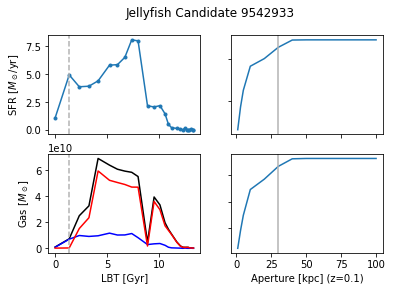

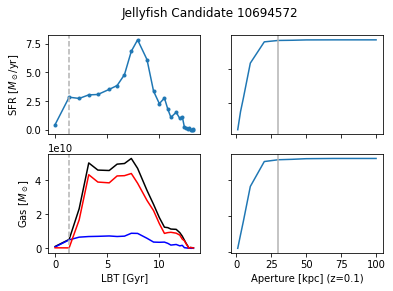

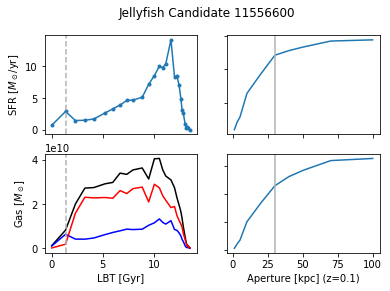

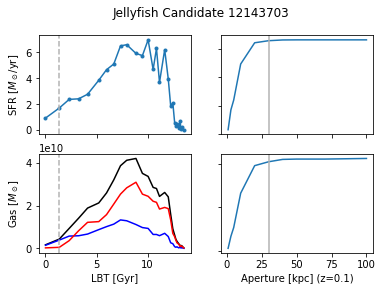

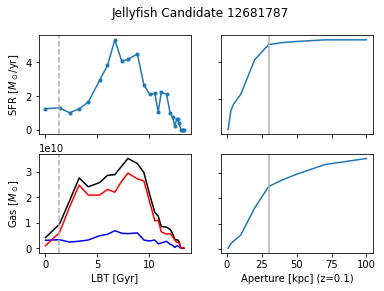

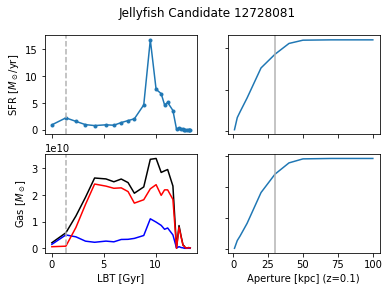

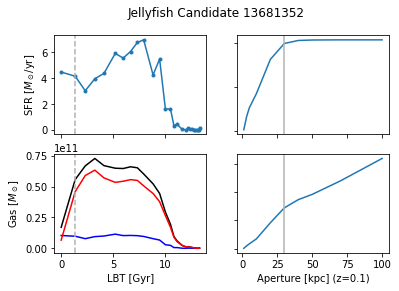

In [27]:
for i in range(len(jellyfish_tree)):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
    fig.suptitle('Jellyfish Candidate '+str(jellyfish_ap[i][0]['ID']))

    # SFR vs time
    ax1.plot(jellyfish_tree[i]['lbt'], jellyfish_tree[i]['SFR'], marker='.')
    ax1.axvline(1.35, 0,8, linestyle='--', c='0.7')
    ax1.set_ylabel('SFR [$M_\odot$/yr]')
    
    # Gas vs. time
    ax3.plot(jellyfish_tree[i]['lbt'], jellyfish_tree[i]['total_gas'], 'k-', label='Total')
    ax3.plot(jellyfish_tree[i]['lbt'], jellyfish_tree[i]['SF_Mass'], 'b-', label='SF')
    ax3.plot(jellyfish_tree[i]['lbt'], jellyfish_tree[i]['NSF_Mass'], 'r-', label='NSF')
    ax3.axvline(1.35, 0,8, linestyle='--', c='0.7')
    ax3.set_xlabel('LBT [Gyr]')
    ax3.set_ylabel('Gas [$M_\odot$]')
#     ax3.legend()
    
    # Set up for aperture
    gases = []
    sfr = []
    
    for size in range(10):
    #     print(jellyfish_ap[0][i]['Mgas'])
        gases.append(jellyfish_ap[i][size]['Mgas'])
        sfr.append(jellyfish_ap[i][size]['SFR'])
    
    # SFR vs Radius
    ax2.plot(apsizes, sfr)
    ax2.axvline(30, c='0.7')
    
    # Gas vs. Radius
    ax4.plot(apsizes, gases)
    ax4.axvline(30, c='0.7')
    ax4.set_xlabel('Aperture [kpc] (z=0.1)')
    
    for ax in fig.get_axes():
# #         ax.set(xlabel='Lookback Time', ylabel='SFR')
        ax.label_outer()
    
    plt.savefig('./LotsPlots/SFR_Gas_'+str(jellyfish_ap[i][0]['ID']))
    plt.show()
    plt.close()